<a href="https://colab.research.google.com/github/anisha99999/DNNs/blob/master/Copy_of_v2_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Copy from shared drive to personal drive and split into train and validation set

In [4]:
import os
import shutil
import random

class_names = ['BMW',  'ROVER','MERCEDES']
for classes in class_names:
  print (classes)
  path1 = '/content/drive/My Drive/s2/BMW/' 
  path2 = '/content/drive/My Drive/s2/ROVER/'
  path3 = '/content/drive/My Drive/s2/MERCEDES/'
  
  path4 = '/content/drive/My Drive/s2/CARS/'
  train = path4 + 'train/'
  val = path4 + 'val/'

  bmw_train = train + 'bmw/'
  bmw_val = val + 'bmw/'

  rover_train = train + 'rover/'
  rover_val = val + 'rover/'

  mercedes_train = train + 'mercedes/'
  mercedes_val = val + 'mercedes/'

  print(path4)
  try:
    os.makedirs (path4)
  except:
    pass
  try:
    #os.makedirs (train)
    os.makedirs (bmw_train)
    os.makedirs (rover_train)
    os.makedirs (mercedes_train)
  except:
    pass
  try:
    #os.makedirs (val)
    os.makedirs (bmw_val)
    os.makedirs (rover_val)
    os.makedirs (mercedes_val)
    
  except:
    pass

  filenames = os.listdir (path1)
  random.shuffle (filenames)
  l = len (filenames)
  print (l)
  print(path1)
  for i, i_file in enumerate (filenames):
    if i % 500 == 0:
      print (i)
      
    if i < 0.9 * l:
      #print(bmw_train+ i_file)
      #print(path2+ i_file)
      shutil.copy (path1 + i_file, bmw_train + i_file)
    else:
      shutil.copy (path1 + i_file, bmw_val+ i_file)
  print ('BMW complete')
  

  filenames1=os.listdir (path2)
  random.shuffle (filenames1)
  l = len (filenames1)
  print (l)

  for i, i_file in enumerate (filenames1):
    if i % 1000 == 0:
      print (i)
    if i < 0.9 * l:
     # print(rover_train+ i_file)
     # print(path2+ i_file)
      shutil.copy (path2 + i_file, rover_train + i_file)
    else:
      shutil.copy (path2 + i_file, rover_val + i_file)
  print ('done')
  print ('Rover complete')

  filenames2=os.listdir (path3)
  random.shuffle (filenames2)
  l = len (filenames2)
  print (l)
  print ('Mercedes complete')

  for i, i_file in enumerate (filenames2):
    if i % 1000 == 0:
      print (i)
    if i < 0.9 * l:
      shutil.copy (path3 + i_file, mercedes_train + i_file)
    else:
      shutil.copy (path3 + i_file,  mercedes_val+ i_file)
  print ('done')
  
  #break

BMW
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done
ROVER
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done
MERCEDES
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done


In [5]:
!ls /content/drive/My\ Drive/s2/CARS/train|wc -l 


3


In [6]:
!ls /content/drive/My\ Drive/s2/CARS/val|wc -l 

3


# copy to colab from drive

In [7]:
!mkdir /content/drive/My\ Drive/s2/CARS/train/bmw
!mkdir /content/drive/My\ Drive/s2/CARS/train/mercedes
!mkdir /content/drive/My\ Drive/s2/CARS/train/rover
!mkdir /content/drive/My\ Drive/s2/CARS/val/bmw
!mkdir /content/drive/My\ Drive/s2/CARS/val/mercedes
!mkdir /content/drive/My\ Drive/s2/CARS/val/rover



mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/bmw’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/mercedes’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/rover’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/bmw’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/mercedes’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/rover’: File exists


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation ([0, 180]),
        transforms.RandomCrop (224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing (),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/My Drive/s2/CARS/'

#print(os.path.join(data_dir, train))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}


#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

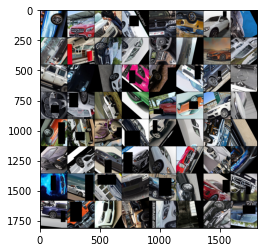

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
device

device(type='cuda', index=0)

In [11]:
from tqdm import notebook

graphs = {'epochs' : [], 'train_acc' : [], 'train_loss' : [], 'val_acc' : [], 'val_loss' : []}
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    tqdm_e = notebook.tqdm ([i + 1 for i in range (num_epochs)], total = num_epochs)
    for i, epoch in enumerate (tqdm_e):
        graphs['epochs'].append (epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print ('Training for Epoch ' + str (epoch) + '... ' + phase)
            tqdm_tl = notebook.tqdm (dataloaders[phase], total = int (len (dataloaders[phase])))
            for inputs, labels in (tqdm_tl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
                graphs['val_acc'].append (epoch_acc.item ())
                graphs['val_loss'].append (epoch_loss)
            else:
                graphs['train_acc'].append (epoch_acc.item ())
                graphs['train_loss'].append (epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_ft = models.resnet18 (pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#model.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for name, child in model_ft.named_children():
    print(name)

print(model_ft.fc)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
Linear(in_features=512, out_features=3, bias=True)


In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Training for Epoch 1... train



train Loss: 0.9998 Acc: 0.4932
Training for Epoch 1... val



val Loss: 0.8786 Acc: 0.5802

Training for Epoch 2... train



train Loss: 0.7986 Acc: 0.6509
Training for Epoch 2... val



val Loss: 0.6915 Acc: 0.7095

Training for Epoch 3... train



train Loss: 0.6898 Acc: 0.7011
Training for Epoch 3... val



val Loss: 0.6044 Acc: 0.7630

Training for Epoch 4... train



train Loss: 0.6126 Acc: 0.7436
Training for Epoch 4... val



val Loss: 0.5417 Acc: 0.7853

Training for Epoch 5... train



train Loss: 0.5616 Acc: 0.7680
Training for Epoch 5... val



val Loss: 0.5315 Acc: 0.7946

Training for Epoch 6... train



train Loss: 0.5197 Acc: 0.7863
Training for Epoch 6... val



val Loss: 0.5246 Acc: 0.7902

Training for Epoch 7... train



train Loss: 0.5067 Acc: 0.7839
Training for Epoch 7... val



val Loss: 0.4776 Acc: 0.8133

Training for Epoch 8... train



train Loss: 0.4654 Acc: 0.8035
Training for Epoch 8... val



val Loss: 0.4188 Acc: 0.8414

Training for Epoch 9... train



train Loss: 0.4729 Acc: 0.7958
Training for Epoch 9... val



val Loss: 0.4160 Acc: 0.8423

Training for Epoch 10... train



train Loss: 0.4602 Acc: 0.8114
Training for Epoch 10... val



val Loss: 0.4049 Acc: 0.8490

Training for Epoch 11... train



train Loss: 0.4682 Acc: 0.8080
Training for Epoch 11... val



val Loss: 0.4071 Acc: 0.8487

Training for Epoch 12... train



train Loss: 0.4552 Acc: 0.8139
Training for Epoch 12... val



val Loss: 0.3962 Acc: 0.8572

Training for Epoch 13... train



train Loss: 0.4458 Acc: 0.8179
Training for Epoch 13... val



val Loss: 0.4000 Acc: 0.8531

Training for Epoch 14... train



train Loss: 0.4314 Acc: 0.8278
Training for Epoch 14... val



val Loss: 0.3817 Acc: 0.8604

Training for Epoch 15... train



train Loss: 0.4445 Acc: 0.8191
Training for Epoch 15... val



val Loss: 0.3985 Acc: 0.8517

Training for Epoch 16... train



train Loss: 0.4456 Acc: 0.8117
Training for Epoch 16... val



val Loss: 0.3875 Acc: 0.8596

Training for Epoch 17... train



train Loss: 0.4510 Acc: 0.8094
Training for Epoch 17... val



val Loss: 0.3883 Acc: 0.8584

Training for Epoch 18... train



train Loss: 0.4331 Acc: 0.8246
Training for Epoch 18... val



val Loss: 0.3766 Acc: 0.8628

Training for Epoch 19... train



train Loss: 0.4407 Acc: 0.8189
Training for Epoch 19... val



val Loss: 0.3898 Acc: 0.8563

Training for Epoch 20... train



train Loss: 0.4445 Acc: 0.8147
Training for Epoch 20... val



val Loss: 0.3871 Acc: 0.8590

Training for Epoch 21... train



train Loss: 0.4438 Acc: 0.8094
Training for Epoch 21... val



val Loss: 0.3871 Acc: 0.8569

Training for Epoch 22... train



train Loss: 0.4332 Acc: 0.8261
Training for Epoch 22... val



val Loss: 0.3877 Acc: 0.8566

Training for Epoch 23... train



train Loss: 0.4619 Acc: 0.8040
Training for Epoch 23... val



val Loss: 0.3850 Acc: 0.8578

Training for Epoch 24... train



train Loss: 0.4547 Acc: 0.8129
Training for Epoch 24... val



val Loss: 0.3827 Acc: 0.8610

Training for Epoch 25... train



train Loss: 0.4496 Acc: 0.8142
Training for Epoch 25... val



val Loss: 0.3926 Acc: 0.8517

Training for Epoch 26... train



train Loss: 0.4494 Acc: 0.8211
Training for Epoch 26... val



val Loss: 0.3736 Acc: 0.8622

Training for Epoch 27... train



train Loss: 0.4537 Acc: 0.8102
Training for Epoch 27... val



val Loss: 0.3860 Acc: 0.8569

Training for Epoch 28... train



train Loss: 0.4349 Acc: 0.8191
Training for Epoch 28... val



val Loss: 0.3796 Acc: 0.8602

Training for Epoch 29... train



train Loss: 0.4326 Acc: 0.8201
Training for Epoch 29... val



val Loss: 0.3841 Acc: 0.8604

Training for Epoch 30... train



train Loss: 0.4465 Acc: 0.8194
Training for Epoch 30... val



val Loss: 0.3813 Acc: 0.8596

Training for Epoch 31... train



train Loss: 0.4517 Acc: 0.8114
Training for Epoch 31... val



val Loss: 0.3936 Acc: 0.8531

Training for Epoch 32... train



train Loss: 0.4364 Acc: 0.8241
Training for Epoch 32... val



val Loss: 0.3761 Acc: 0.8607

Training for Epoch 33... train



train Loss: 0.4431 Acc: 0.8204
Training for Epoch 33... val



val Loss: 0.3848 Acc: 0.8552

Training for Epoch 34... train



train Loss: 0.4311 Acc: 0.8204
Training for Epoch 34... val



val Loss: 0.3931 Acc: 0.8528

Training for Epoch 35... train



train Loss: 0.4560 Acc: 0.8159
Training for Epoch 35... val



val Loss: 0.3796 Acc: 0.8602

Training for Epoch 36... train



train Loss: 0.4493 Acc: 0.8159
Training for Epoch 36... val



val Loss: 0.3866 Acc: 0.8572

Training for Epoch 37... train



train Loss: 0.4480 Acc: 0.8142
Training for Epoch 37... val



val Loss: 0.3871 Acc: 0.8584

Training for Epoch 38... train



train Loss: 0.4409 Acc: 0.8186
Training for Epoch 38... val



val Loss: 0.3867 Acc: 0.8578

Training for Epoch 39... train



train Loss: 0.4417 Acc: 0.8189
Training for Epoch 39... val



val Loss: 0.3849 Acc: 0.8587

Training for Epoch 40... train



train Loss: 0.4250 Acc: 0.8243
Training for Epoch 40... val



val Loss: 0.3898 Acc: 0.8546

Training for Epoch 41... train



train Loss: 0.4378 Acc: 0.8288
Training for Epoch 41... val



val Loss: 0.3842 Acc: 0.8596

Training for Epoch 42... train



train Loss: 0.4501 Acc: 0.8191
Training for Epoch 42... val



val Loss: 0.3895 Acc: 0.8563

Training for Epoch 43... train



train Loss: 0.4463 Acc: 0.8189
Training for Epoch 43... val



val Loss: 0.3818 Acc: 0.8593

Training for Epoch 44... train



train Loss: 0.4416 Acc: 0.8124
Training for Epoch 44... val



val Loss: 0.3801 Acc: 0.8593

Training for Epoch 45... train



train Loss: 0.4373 Acc: 0.8251
Training for Epoch 45... val



val Loss: 0.3953 Acc: 0.8523

Training for Epoch 46... train



train Loss: 0.4382 Acc: 0.8154
Training for Epoch 46... val



val Loss: 0.3748 Acc: 0.8613

Training for Epoch 47... train



train Loss: 0.4351 Acc: 0.8194
Training for Epoch 47... val



val Loss: 0.3871 Acc: 0.8552

Training for Epoch 48... train



train Loss: 0.4421 Acc: 0.8139
Training for Epoch 48... val



val Loss: 0.3953 Acc: 0.8517

Training for Epoch 49... train



train Loss: 0.4407 Acc: 0.8191
Training for Epoch 49... val



val Loss: 0.3776 Acc: 0.8599

Training for Epoch 50... train



train Loss: 0.4346 Acc: 0.8216
Training for Epoch 50... val



val Loss: 0.3880 Acc: 0.8558


Training complete in 153m 31s
Best val Acc: 0.862785


In [14]:
print (graphs)

{'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'train_acc': [0.49316770186335407, 0.6509316770186335, 0.7011180124223603, 0.7436024844720497, 0.7679503105590062, 0.7863354037267081, 0.7838509316770187, 0.8034782608695652, 0.795776397515528, 0.8114285714285715, 0.8079503105590062, 0.8139130434782609, 0.817888198757764, 0.8278260869565218, 0.8191304347826087, 0.8116770186335404, 0.80944099378882, 0.8245962732919255, 0.8188819875776397, 0.8146583850931677, 0.80944099378882, 0.8260869565217391, 0.8039751552795031, 0.8129192546583851, 0.8141614906832298, 0.8211180124223603, 0.8101863354037268, 0.8191304347826087, 0.8201242236024845, 0.8193788819875777, 0.8114285714285715, 0.8240993788819876, 0.8203726708074535, 0.8203726708074535, 0.8159006211180124, 0.8159006211180124, 0.8141614906832298, 0.8186335403726709, 0.8188819875776397, 0.82434

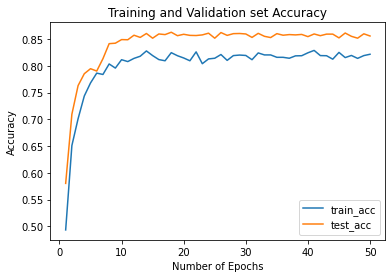

In [15]:
plt.plot (graphs['epochs'][:50], graphs['train_acc'], label = 'train_acc')
plt.plot (graphs['epochs'][:50], graphs['val_acc'], label = 'test_acc')
plt.xlabel ('Number of Epochs')
plt.ylabel ('Accuracy')
plt.title ('Training and Validation set Accuracy')
plt.legend ()
plt.show ()

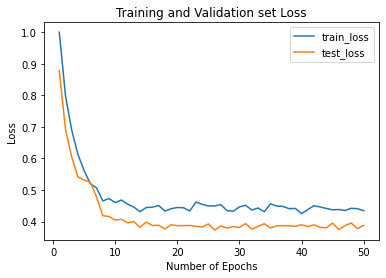

In [16]:
plt.plot (graphs['epochs'][:50], graphs['train_loss'], label = 'train_loss')
plt.plot (graphs['epochs'][:50], graphs['val_loss'], label = 'test_loss')
plt.xlabel ('Number of Epochs')
plt.ylabel ('Loss')
plt.title ('Training and Validation set Loss')
plt.legend ()
plt.show ()

In [17]:
def visualize_model(model, abcd, num_images=20):
    print (class_names[abcd])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots (2, 5, figsize = (40, 15))
    x = 0
    y = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if labels[j] != abcd or preds[j] == labels[j]:
                    continue
                images_so_far += 1
                #ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                z = inputs.cpu().data[j]
                z = z.numpy().transpose((1, 2, 0))
                z = np.clip (z, 0, 1)

                ax[y, x].axis ('off')
                ax[y, x].set_title ('pred as {}'.format(class_names[preds[j]]), fontdict={'fontsize': 22, 'fontweight': 'medium'})
                ax[y, x].imshow (z)
                
                x += 1
                if x == 5:
                    y += 1
                    x = 0
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

rover


IndexError: ignored

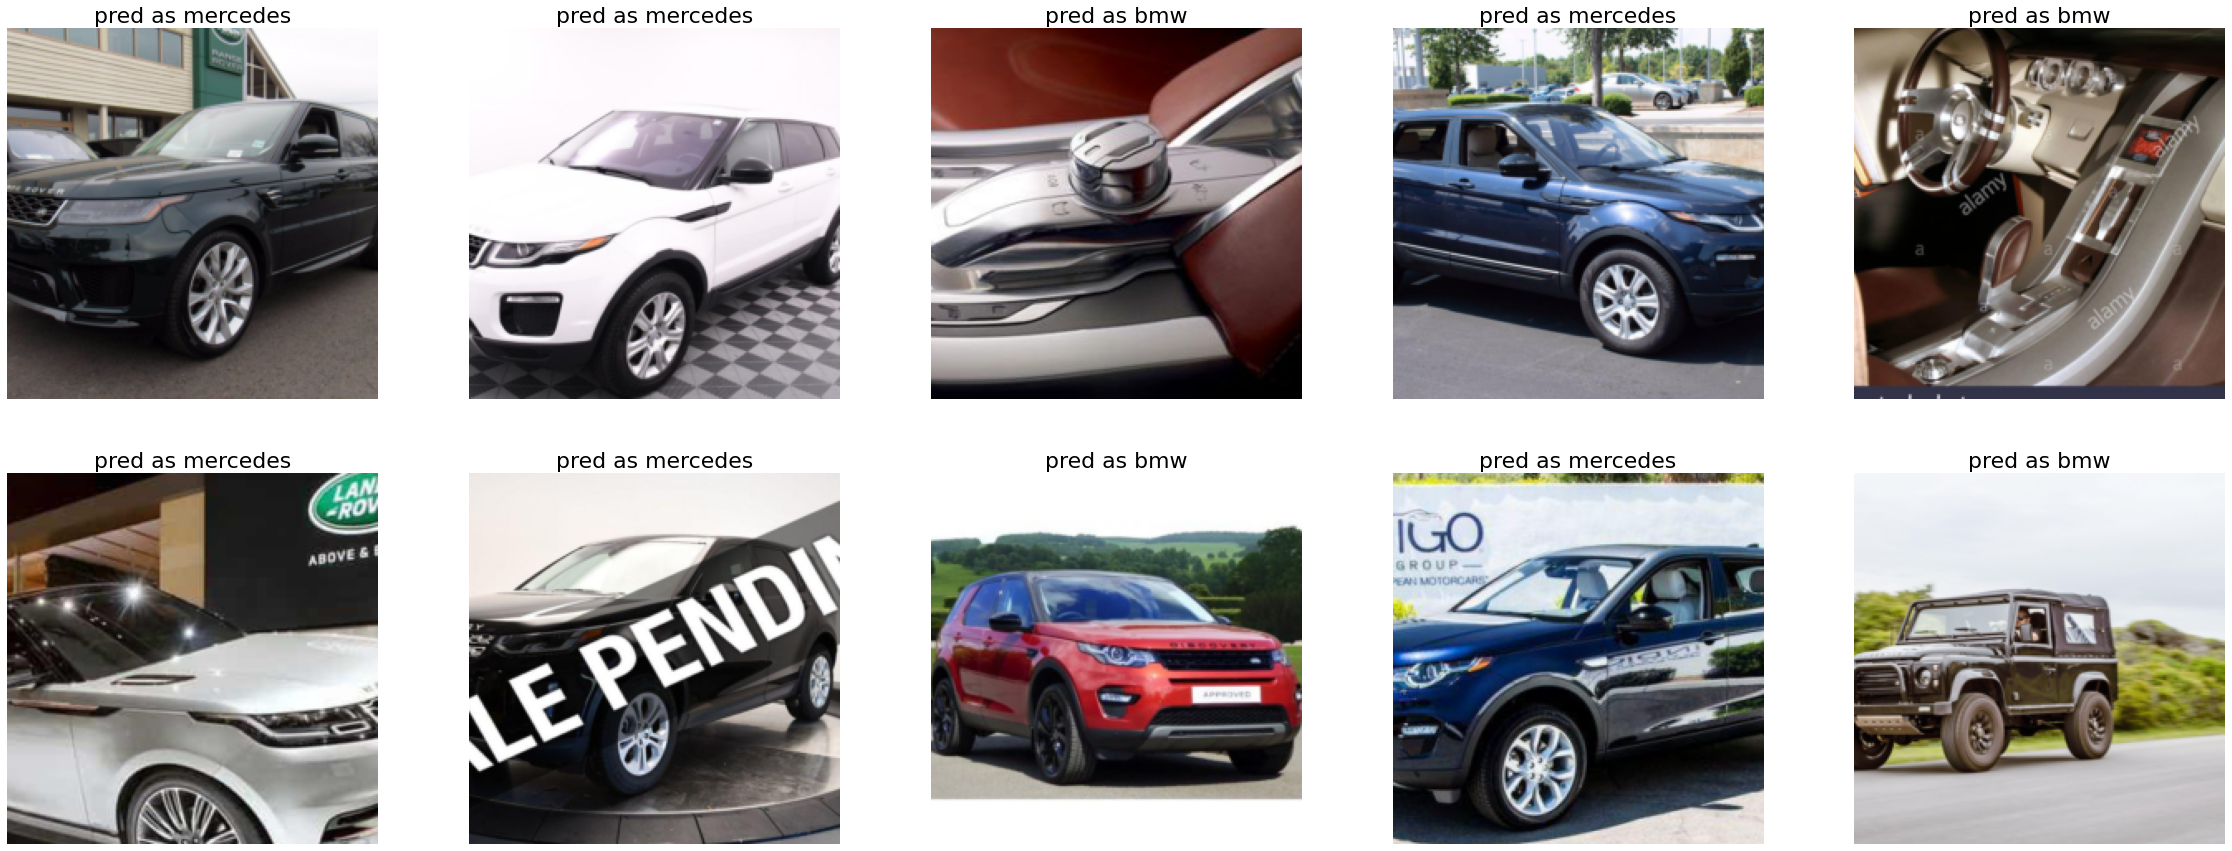

In [18]:
#model_ft = model_ft.to (device)
visualize_model(model_ft, 2)

In [ ]:
print (model_ft)
#model_ft = model_ft.to ('cpu')
model_ft.eval ()
traced_model = torch.jit.trace (model_ft, torch.randn (1, 3, 224, 224))
traced_model.save ('/content/drive/My Drive/s2/resnet_custom.pt')

In [ ]:
#import json
#with open ('/content/drive/My Drive/eva/class_names.json', 'w') as openfile:
  #json.dump (class_names, openfile)